### Use bonus plates (length of 4)

In [8]:
import random as rd
import numpy as np

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.models import Model, load_model, Sequential

from tensorflow.keras import backend
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
#
# Definitions
#
# RED = 0.2
# GREEN = 0.4
# BLUE = 0.6
# PURPLE = 0.8
#
colors = [0.2, 0.4, 0.6, 0.8]

### Functions must be changed

In [ ]:
def color_fits(field, i, j, new_color):
    """
    Checks if two items to the left or two colors to the top are NOT of the same color as the new item.
    Input:
    - field: battfield, numpy array
    - i, j: position on the new item, int, within field.shape
    - new_color: color of the new item, float
    Output:
    - boolean: True, if the new item is ok
    """
    # Check two colors to the left
    if (j > 1):
        if (round(field[i, j - 2] % 1.0, 1) == new_color) and (round(field[i, j - 1] % 1.0, 1) == new_color):
            return False
        
    # Check two colors to the right
    if (j < 4):
        if (round(field[i, j + 2] % 1.0, 1) == new_color) and (round(field[i, j + 1] % 1.0, 1) == new_color):
            return False
    
    # Check two color to the top
    if (i < 5):
        if (round(field[i + 2, j] % 1.0, 1) == new_color) and (round(field[i + 1, j] % 1.0, 1) == new_color):
            return False
    
    return True

### Functions left unchanged

In [ ]:
def initialize_field(field):
    """
    Initialization of the battle field.
    Move from bottom left corner and add new elements.
    Input: 
    - field: numpy array of zeros, 7x6
    Output:
    - field: numpy array of floats, 7x6
    """
    colors = [0.2, 0.4, 0.6, 0.8]
    
    for i in list(range(field.shape[0]))[::-1]:
        for j in range(field.shape[1]):
            rd.seed()
            new_color = rd.choice(colors)
            
            while not color_fits(field, i, j, new_color):
                rd.seed()
                new_color = rd.choice(colors)
                
            field[i, j] = new_color
    
    return field

In [ ]:
def visualize_field(field):
    """
    Visualizes the battle field in colored circles
    Handles bonus plates
    Input:
    - field: numpy array of floats, 7x6
    Output:
    - None
    """
    fig, ax = plt.subplots(figsize=(5, 7))

    ax.set_xlim((0, 10))
    ax.set_ylim((0, 13))

    circles = []

    for ii in range(7):
        for jj in range(6):
            if (field[ii, jj] == 0.2):
                clr = "red"
            elif (field[ii, jj] == 0.4):
                clr = "lightgreen"
            elif (field[ii, jj] == 0.6):
                clr = "cyan"
            else:
                clr = "purple"

            if (field[ii, jj] // 1 == 1.0):
                circles.append( mpatches.RegularPolygon((jj + 1, 7 - ii), numVertices=4, radius=0.4, color=clr) )
            else:
                circles.append( mpatches.Circle((jj + 1, 7 - ii), radius=0.4, color=clr) )

    for circ in circles:
        ax.add_artist(circ)
        
    return

In [ ]:
def get_length_to_right(ribbon, color, length):
    """
    TODO
    """
    length = length + 1
    
    if (len(ribbon) == 0) or (ribbon[0] != color):
        return length

    return get_length_to_right(ribbon[1:], color, length)

In [ ]:
def fill_field(field, colors):
    """
    Наполняет поле после сжигания рядов.
    Сдвигает фишки вниз, заполняя верхний ряд каждый раз так, чтобы верхний ряд не создавал халявной тройки
    Начинает с левого нижнего угла, чтобы переиспользовать color_fits()
    Input:
    - field: numpy array of floats, 7x6
    - colors: list of 4 floats - color values, see the definition above
    Output:
    - numpy array of floats, 7x6 - updated field
    """
    for ii in list(range(7))[::-1]:
        for jj in range(6):
            while (field[ii, jj] == 0.):
                # Опускаем на один вниз
                # Если мы в самом верхнем ряду, то опускать не нужно
                if (ii != 0):
                    for iii in list(range(1, ii + 1))[::-1]:
                        field[iii, jj] = field[iii - 1, jj]

                # Заполняем верх
                new_color = rd.choice(colors)

                while not color_fits(field, 0, jj, new_color):
                    new_color = rd.choice(colors)

                field[0, jj] = new_color  
                
    return field

In [ ]:
def make_move_v2(field, move):
    """
    Physically moves plates according to the move
    Input:
    - field: numpy array of floats, 7x6
    - move: particular move to make, 1<=move<=142
    Output:
    - new_field: updated field with two swapped plates
    - plate_start: coordinates of the plate that started the move, tuple (row, column)
    - plate_end: cooredinates of the plate that ended the move, tuple (row, column)
    """
    start_y, start_x, direction = process_move_142(move)
    
    if (direction == "down"):
        end_x = start_x
        end_y = start_y + 1
    elif (direction == "up"):
        end_x = start_x
        end_y = start_y - 1
    elif (direction == "left"):
        end_x = start_x - 1
        end_y = start_y 
    else:
        end_x = start_x + 1
        end_y = start_y 

    # Swap two plates and create new (modified) field
    new_field = np.array(field)
    source_color = field[start_y - 1, start_x - 1]
    new_field[start_y - 1, start_x - 1] = field[end_y - 1, end_x - 1]
    new_field[end_y - 1, end_x - 1] = source_color
        
    return new_field, (start_y - 1, start_x - 1), (end_y - 1, end_x - 1)

In [28]:
def calculate_score_v2(field, plate_from, plate_to):
    """
    Calculates the score in the field. 
    Replaces all sets with zeros.
    Handles bonus plates: replaces required rows with zeros (Type 4)
    Puts bonus plates, should any set be of the length of 4
    Input:
    - field: numpy array of floats, 7x6
    - plate_from: coordinates of the plate where the move starts, tuple (row, column)
    - plate_to: coordinates of the plate where the move ends, tuple (row, column)
    Output:
    - score: int, 0+
    - field: modified field
    """
    # Get all sets with possible bonus plates
    sets, bonus_plates = get_sets(field)

    # Set all requires plates to zero
    #
    # First handle sets
    for st in sets:
        row = st[0]
        col = st[1]
        lng = st[2]
        drc = st[3]

        if (drc == 0):
            field[row, col:(col + lng - 1)] = 0
        else:
            field[row:(row + lng - 1), col] = 0
    #       
    # Then handle bonus plates/rows
    for pl in bonus_plates:
        row = pl[0]
        col = pl[1]
        typ = pl[2]

        if (typ == 4):
            field[row, :] = 0

    # Calculate score
    score = (field == 0.).sum()

    # Put new bonus plates. Specially care for the move coordinates
    for st in sets:
        row = st[0]
        col = st[1]
        lng = st[2]
        drc = st[3]
        clr = st[4]

        if (lng >= 4):
            if (plate_in_set(plate_from, row, col, lng, drc)):
                # Move start plate in set. Put new bonus plate according to the move coordinates
                field[plate_from[0], plate_from[1]] = clr + 1.0
            elif (plate_in_set(plate_to, row, col, lng, drc)):
                # Move end plate in set. Put new bonus plate according to the move coordinates
                field[plate_to[0], plate_to[1]] = clr + 1.0
            else:
                # Just put the new bonus plate at the very right/bottom of the set
                # This CANNOT happen during the manual move!
                # It CAN ONLY HAPPEN when the field is randomly filled with new plates
                if (drc == 0):
                    field[row, col + lng - 1] = clr + 1.0
                else:
                    field[row + lng - 1, col] = clr + 1.0

    return score, field


def get_sets(field):
    """
    Finds all sets and all bonus plates included into those sets
    Input:
    - field: numpy array of floats, 7x6
    Output:
    - list of sets coordinates: list of tuples (row_start, column_start, set_length, direction, color), counting from top left corner
      Direction is either 0 (horizontal) or 1 (vertical)
    - list of bonus plates included into sets: list of tuples (row, column, type). 
      Type is either 4 or 5 (reserved for future)
    """
    perm_bonus_plates = []
    perm_sets = []

    # Find all 3+ sets in horizontal row
    for ii in range(field.shape[0]):
        temp_bonus_plates = []
        jj = 0
        len = 1
        while (jj < field.shape[1]):
            if (jj > 0):
                if (round(field[ii, jj] % 1.0, 1) == round(field[ii, jj - 1] % 1.0, 1)):
                    len = len + 1
                else:
                    if (len >= 3):
                        # Add temp list of bonus plates to the permanent list of bonus plates
                        perm_bonus_plates = perm_bonus_plates + temp_bonus_plates
                        
                        # Add to permanent list of sets
                        perm_sets.append((ii, jj - len, len, 0, round(field[ii, jj - 1] % 1.0, 1))
                        
                    temp_bonus_plates = []
                    len = 1
            
            if (field[ii, jj] > 1.):
                # Add to temp list of bonus plates
                temp_bonus_plates.append((ii, jj, 4))
            
            jj = jj + 1
            
        if (len >= 3):
            # Add temp list of bonus plates to the permanent list of bonus plates
            perm_bonus_plates = perm_bonus_plates + temp_bonus_plates

            # Add to permanent list of sets
            perm_sets.append((ii, jj - len, len, 0, round(field[ii, jj - 1] % 1.0, 1))

    # Find all 3+ sets in vertical columns
    for jj in range(field.shape[1]):
        temp_bonus_plates = []
        ii = 0
        len = 1
        while (ii < field.shape[0]):
            if (ii > 0):
                if (round(field[ii, jj] % 1.0, 1) == round(field[ii - 1, jj] % 1.0, 1)):
                    len = len + 1
                else:
                    if (len >= 3):
                        # Add temp list of bonus plates to the permanent list of bonus plates
                        perm_bonus_plates = perm_bonus_plates + temp_bonus_plates
                        
                        # Add to permanent list of sets
                        perm_sets.append((ii - len, jj, len, 1, round(field[ii - 1, jj] % 1.0, 1))
                        
                    temp_bonus_plates = []
                    len = 1
            
            if (field[ii, jj] > 1.):
                # Add to temp list of bonus plates
                temp_bonus_plates.append((ii, jj, 4))
            
            ii = ii + 1
            
        if (len >= 3):
            # Add temp list of bonus plates to the permanent list of bonus plates
            perm_bonus_plates = perm_bonus_plates + temp_bonus_plates

            # Add to permanent list of sets
            perm_sets.append((ii - len, jj, len, 1, round(field[ii - 1, jj] % 1.0, 1))
            
    return perm_sets, perm_bonus_plates

In [4]:
ЭТА ДОЛЖНА ОТОБРАЖАТЬ БОНУСНЫЕ БЛЮДА ПО-ДРУГОМУ



In [3]:
0.8 // 1

0.0

In [8]:
ДОЛЖНА ОТДАВАТЬ БЛЮДО, С КОТОРОГО НАЧАЛСЯ ХОД
ОПТИМИЗАЦИЯ: МОЖНО СРАЗУ ОТДАВАТЬ КООРДИНАТЫ ОБЕИХ КЛЕТОК, В КОТОРЫХ БУДЕТ ХОД
((ряд_откуда, колонка_откуда), (ряд_куда, колонка_куда))
ОПТИМИЗАЦИЯ: ПРЕВРАТИТЬ ЕЁ В СЛОВАРЬ

def process_move_142(move):
    """
    There are total 142 possible moves:
    - along the vertical axis: 6 + 5*12 + 6 = 6*12 = 72
    - along the norizontal axis: 7 + 4*14 + 7 = 5*14 = 70
    
    The _move_ parameter:
    Vertical moves:
    move in 1-6: row 1, column _move_, down
    move in 7-66: row (move - 7 // 12) + 2, column (((move - 7) % 12) // 2) + 1, direction _move_ % 2 == 0 - up, otherwise - down
    move in 67-72: row 7, column (move - 66), up
    
    Horizontal moves:
    move in 73-79: row (move - 72), column 1, right
    move in 80-135: row ((move - 80) % 14) // 2 + 1, column ((move - 80) // 14) + 2, direction _move_ % 2 == 0 - left, otherwise - right
    move in 136-142: row (move - 135), column 6, left    
    
    Input:
    - move: move code, 1-142, int
    Output:
    - row: row where the moved object located, 1-7, int
    - column: row where the moved object located, 1-6, int
    - direction: "up"/"down"/"left"/"right", string
    """
    # Process move
    if (move in range(1, 7)):
        row = 1
        column = move
        direction = "down"
    elif (move in range(7, 67)):
        row = ((move - 7) // 12) + 2
        column = (((move - 7) % 12) // 2) + 1
        direction = "up" if (move % 2 == 0) else "down"
    elif (move in range(67, 73)):
        row = 7
        column = move - 66
        direction = "up"
    elif (move in range(73, 80)):
        row = move - 72
        column = 1
        direction = "right"
    elif (move in range(80, 136)):
        row = (((move - 80) % 14) // 2) + 1
        column = ((move - 80) // 14) + 2
        direction = "left" if (move % 2 == 0) else "right"
    else:
        row = move - 135
        column = 6
        direction = "left"
    
    return row, column, direction

In [ ]:
def plate_in_set(plate, row, col, length, direction):
    """
    Checks whether plate is with the set given by row, col, length, direction
    Input:
    - plate: plate location, tuple (row, column)
    - row: row where the set starts
    - col: column where the set starts
    - length: the set's length
    - direction: the set's direction
    Output:
    - True if the plate is within the set, False otherwise
    """
    if (direction == 0):
        # Horizontal set
        if ((plate[0] <> row) or (plate[1] < col) or (plate[1] > (col + length - 1))):
            return False
    else:
        # Vertucal set
        if ((plate[1] <> col) or (plate[0] < row) or (plate[0] > (row + length - 1))):
            return False
        
    return True

In [41]:
# Variables
moves_memory = []
COUNTER_OF_SUCCESSFUL_MOVES = 0

# Constants
NUMBER_OF_MOVES_IN_GAME = 50
NUMBER_OF_GAMES = 15000



In [40]:
%%time

for g in range(NUMBER_OF_GAMES):
    # Начинаем одну игру
    game_score = 0

    # Initialize the game field
    field = np.zeros((7, 6))
    field = initialize_field(field)

    for m in range(NUMBER_OF_MOVES_IN_GAME):
        # Общий счет хода
        reward = 0
        
        # Randomly select a move
        rd.seed()
        move = rd.choice(list(range(1, 143)))

        # Make the move
        s_before = field
        new_field, plate_a, plate_b = make_move_v2(field, move)

        # Calculate the score and update the field
        score, new_field = calculate_score_v2(new_field, plate_a, plate_b)
        
        successful_move_flag = False

        # Если ход результативный, то обновляем поле и проверяем, получились ли новые цветовые ряды
        while (score > 0.):
            if (not successful_move_flag):
                COUNTER_OF_SUCCESSFUL_MOVES = COUNTER_OF_SUCCESSFUL_MOVES + 1
                successful_move_flag = True

            # Суммируем набранные очки
            reward = reward + score

            # Сдвигаем фишки вниз, заполняя верхний ряд каждый раз так, чтобы верхний ряд не создавал халявной тройки
            # Начинаем с левого нижнего угла (чтобы переиспользовать color_fits())
            new_field = fill_field(new_field, colors)

            # Считаем очки и обрабатываем новые возможные цветные ряды
            score, new_field = calculate_score_v2(new_field, (-1, -1), (-1, -1))

        # Если ход успешный, то меняем поле
        if (successful_move_flag):
            field = new_field
            
        # Увеличиваем счет игры
        game_score = game_score + reward
            
        # Сохраняем ход, очки и все состояния в память   
        s_after = field
        moves_memory.append((s_before, move, reward, s_after)) 

print("The number of successful moves is", COUNTER_OF_SUCCESSFUL_MOVES)

KeyboardInterrupt: 

In [44]:
ttt = np.array([[1, 0, 0, 0], [0, 0, 0, 3], [2, 1, 4, 2]])
print(ttt)
print((ttt == 0.).sum())

[[1 0 0 0]
 [0 0 0 3]
 [2 1 4 2]]
6


In [10]:
# Проверка, что в случае неуспешного (нулевого) хода начальное и конечное состояния совпадают
for item in moves_memory:
    if (item[2] == 0):
        if ( np.abs(item[0] - item[3]).sum() != 0.  ):
            print("Error!")

In [11]:
# Нужно проредить память ходов, чтобы сделать соотношение успешных и неуспешных ходов примерно 1:1
moves_to_remove = len(moves_memory) - 2 * COUNTER_OF_SUCCESSFUL_MOVES

i = 0

while (i < moves_to_remove):
    elem = rd.randint(0, len(moves_memory) - 1)
    
    if (moves_memory[elem][2] == 0.):
        moves_memory.pop(elem)
        i = i + 1
    else:
        rd.seed()
        
print("{} items cleared from moves_memory".format(moves_to_remove))
print("Final length of moves_memory is", len(moves_memory))

455088 items cleared from replay_memory


### Обучение нейронной сети

#### 28.03.2019 Score: 446

In [13]:
# Constants
NUM_OF_EPOCHS = 500
MINIBATCH_SIZE = 64

# Пенальти за будущие ходы
GAMMA = 0.2

# Learning curve
loss_history = []

In [14]:
def predict_max_score(field, aero_cnn, number_of_moves, debug_flag = False):
    """
    TODO 
    """
    X_data = ()
           
    for move in range(1, number_of_moves + 1):
        swapped = make_move(np.array(field), move)
        X_data = X_data + ( swapped, )
    
    # Теперь выбираем наиболее успешый ход из всех успешных
    X_data = np.expand_dims(np.stack(X_data, axis=0), axis=3)
    
    prediction = aero_cnn.predict(X_data)
    
    if (debug_flag):
        print("DEBUG", prediction)
    
    best_move_score = prediction.max()
    best_move_number = prediction.argmax() + 1
    
    return best_move_score, best_move_number

In [15]:
if (True):
    # Загрузим ранее созданную модель
    aero_cnn = load_model('Aero_CNN_v1')
else:
    # Готовим модель
    # v6.0 pure Keras 20190323
    aero_cnn = Sequential()

    aero_cnn.add(Conv2D(128, kernel_size=3, strides = (1, 1), padding='same', activation='relu', data_format = 'channels_last', input_shape=(7, 6, 1)))
    aero_cnn.add(Conv2D(64, kernel_size=3, strides = (1, 1), padding='same', activation='relu'))
    aero_cnn.add(Flatten())
    aero_cnn.add(Dense(32, activation='relu'))
    aero_cnn.add(Dense(1))

    aero_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    
    aero_cnn.summary()

Instructions for updating:
Use tf.cast instead.


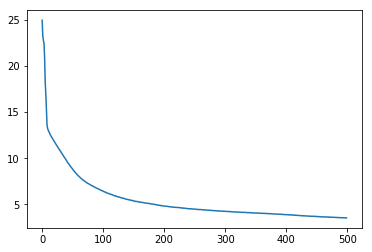

Wall time: 16h 54min 50s


In [17]:
%%time

# Строим X_train и Y_train
X_train = ()
Y_train = np.zeros((len(replay_memory), 1))

for num, item in enumerate(replay_memory):
    s_before = item[0]
    actn = item[1]
    rwrd = item[2]
    s_after = item[3]

    X_train = X_train + (make_move(s_before, actn),)
    #Y_train[num, 0] = rwrd + GAMMA * predict_max_score(s_after, aero_cnn, 142)[0]
    Y_train[num, 0] = rwrd

X_train = np.expand_dims(np.stack(X_train, axis=0), axis=3)

# Делаем градиентный спуск, подкручиваем веса сети
history = aero_cnn.fit(X_train, Y_train, batch_size=MINIBATCH_SIZE, epochs=NUM_OF_EPOCHS, verbose=0)
#loss_history = loss_history + history.history['loss']

plt.plot(history.history['loss'])
plt.show()

### Now the CNN has been trained.
### Start the long reinforcement-learning cycle

In [42]:
# Definitions
#GAMES_TO_PLAY = 1000000
GAMES_TO_PLAY = 2
REPLAY_MEMORY_SIZE = 8192
RANDOM_MOVE_PROB = 0.5
DYNAMIC_LEARNING_EPOCHS = 10

# Variables
MAXIMUM_SCORE = 0
TOTAL_SCORE = 0.0
AVG_SCORE_HIST = []
TOTAL_SUCCESSFUL_MOVES = 0.0
AVG_SUCC_MOVES_HIST = []

In [43]:
# Initialize replay_memory
replay_memory = []

In [46]:
%%time

for game in range(GAMES_TO_PLAY):
    # Начинаем одну игру
    game_score = 0
    successful_moves = 0

    # Initialize the game field
    field = np.zeros((7, 6))
    field = initialize_field(field)

    for m in range(NUMBER_OF_MOVES_IN_GAME):
        # Общий счет хода
        reward = 0

        # CNN selects a move
        # Пока не будем использовать случайные ходы, хотя так описано в статье
        # Если в replay_memory меньше 64 ходов, то делаем эти ходы случайным образом
        if (len(replay_memory) < MINIBATCH_SIZE):
            move = rd.randint(1, 142) 
        else:
            move = predict_max_score(field, aero_cnn, 142)[1]

        # Make the move
        s_before = field
        new_field = make_move(field, move)

        # Считаем очки за ход
        temp_field = calculate_score(new_field)
        score = temp_field.sum()
        successful_move_flag = False

        # Если ход результативный, то обновляем поле и проверяем, получились ли новые цветовые ряды
        while (score > 0.):
            if (not successful_move_flag):
                successful_moves = successful_moves + 1
                successful_move_flag = True

            # Суммируем набранные очки
            reward = reward + score

            # Обнуляем собранные цветные ряды
            new_field = np.multiply(new_field, 1.0 - temp_field)

            # Сдвигаем фишки вниз, заполняя верхний ряд каждый раз так, чтобы верхний ряд не создавал халявной тройки
            # Начинаем с левого нижнего угла (чтобы переиспользовать color_fits())
            new_field = fill_field(new_field, colors)

            # Проверяем, получились ли новые цветные ряды
            temp_field = calculate_score(new_field)
            score = temp_field.sum()

        # Увеличиваем счет игры
        game_score = game_score + reward

        #
        # Train CNN based on the score
        #
        if (len(replay_memory) >= MINIBATCH_SIZE):
            # Случайно выбираем 64 хода из памяти
            samples = rd.sample(replay_memory, MINIBATCH_SIZE)
            # Один ход (пусть будет последний) заполняем нашим реальным ходом
            samples[MINIBATCH_SIZE - 1] = (field, move, reward, new_field)

            # Строим X_train и Y_train
            X_train = ()
            Y_train = np.zeros((MINIBATCH_SIZE, 1))

            for num, item in enumerate(samples):
                s_before = item[0]
                actn = item[1]
                rwrd = item[2]
                s_after = item[3]

                X_train = X_train + (make_move(s_before, actn),)
                Y_train[num, 0] = rwrd + GAMMA * predict_max_score(s_after, aero_cnn, 142)[0]

            # 64-й ход - реальный, поэтому для него предсказание будущего не нужно. Ставим фактическое значение
            Y_train[MINIBATCH_SIZE - 1, 0] = rwrd
            # Делаем правильный по размеру тензор
            X_train = np.expand_dims(np.stack(X_train, axis=0), axis=3)
            # Подкручиваем сеть
            aero_cnn.fit(X_train, Y_train, epochs=DYNAMIC_LEARNING_EPOCHS, verbose=0)

            if (len(replay_memory) == REPLAY_MEMORY_SIZE):
                replay_memory.pop(0)

        # Add new move to the replay memory
        replay_memory.append((field, move, reward, new_field))

        # Если ход успешный, то меняем поле
        if (successful_move_flag):
            field = new_field

    #
    # Calculate and display overall stats
    #
    # Проверяем, не обновили ли максимум
    if (game_score > MAXIMUM_SCORE):
        print("New maximum: {}, after {} games.".format(game_score, game))
        MAXIMUM_SCORE = game_score
        
    # После каждой тысячи игр выводим средний балл за игру, среднее число успешных ходов за игру
    TOTAL_SCORE = TOTAL_SCORE + game_score
    TOTAL_SUCCESSFUL_MOVES = TOTAL_SUCCESSFUL_MOVES + successful_moves
    
    if ((game % 1000 == 0) and (game > 0)):
        avg_score = TOTAL_SCORE / game
        AVG_SCORE_HIST.append(avg_score)
        
        avg_succ_moves = TOTAL_SUCCESSFUL_MOVES / game
        AVG_SUCC_MOVES_HIST.append(avg_succ_moves)

        print("Average score = {}, Average number of successful moves = {}".format(avg_score, avg_succ_moves))        
        
# По окончании мероприятия посмотрим историю среднего балла
plt.plot(AVG_SCORE_HIST, color='red')
plt.plot(AVG_SUCC_MOVES_HIST, color='blue')
plt.show()

New maximum: 426.0, after 0 games.


NameError: name 'TOTAL_SUCCESSFUL_MOVES' is not defined

In [45]:
successful_moves

39

In [34]:
new_field = make_move(field, move)
print(new_field)

[[0.8 0.4 0.8 0.4 0.4 0.8]
 [0.2 0.2 0.6 0.8 0.8 0.2]
 [0.4 0.8 0.2 0.6 0.6 0.2]
 [0.4 0.4 0.6 0.8 0.4 0.8]
 [0.2 0.8 0.2 0.4 0.2 0.4]
 [0.6 0.4 0.2 0.4 0.6 0.4]
 [0.2 0.8 0.8 0.8 0.2 0.2]]


In [35]:
temp_field = calculate_score(new_field)

In [36]:
new_field = np.multiply(new_field, 1.0 - temp_field)

In [37]:
fill_field(new_field, colors)

In [23]:
#
# Save model
#
# v1: 20190329, trained on len(replay_memory) = 294912
#aero_cnn.save("Aero_CNN_v1")

In [19]:
process_move_142(75)

(3, 1, 'right')

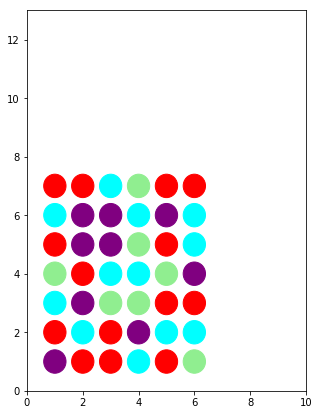

In [22]:
visualize_field(field)

In [98]:
process_move_142(83)

(2, 2, 'right')

(1, 1, 'down')
(1, 2, 'down')
(1, 3, 'down')
(1, 4, 'down')
(1, 5, 'down')
(1, 6, 'down')
(2, 1, 'down')
(2, 1, 'up')
(2, 2, 'down')


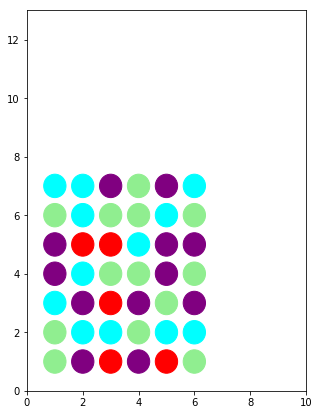

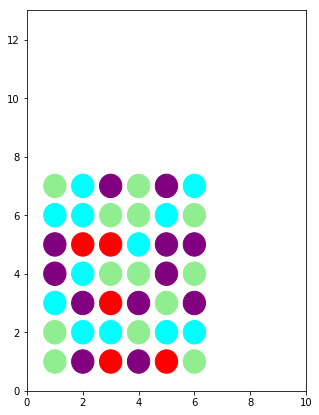

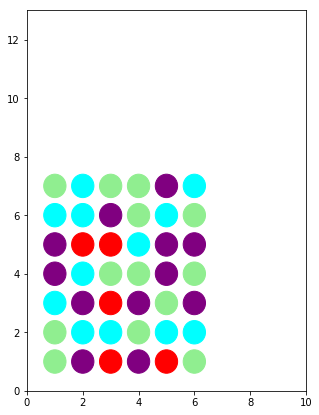

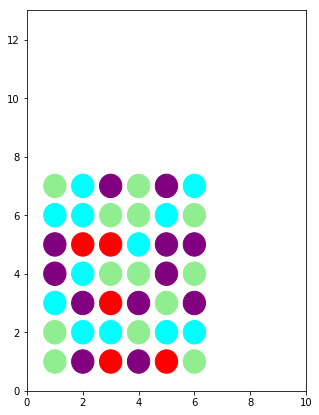

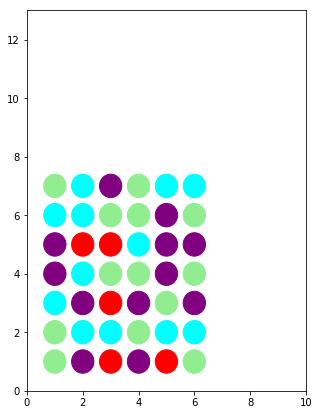

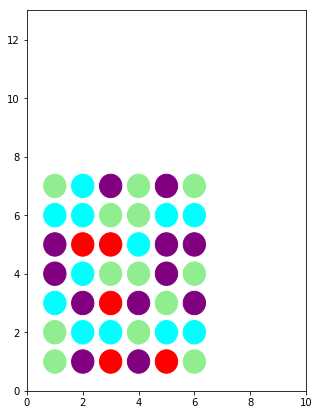

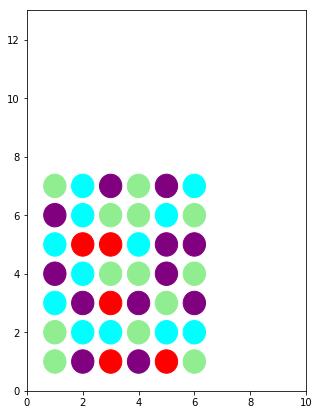

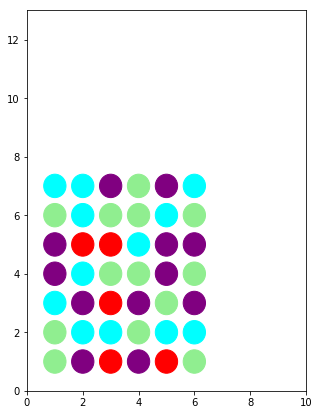

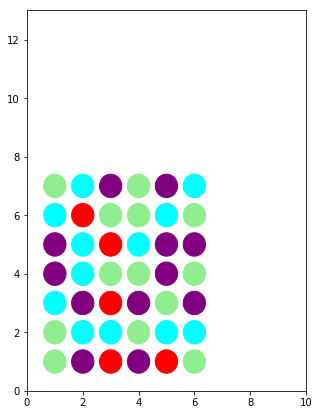

In [46]:
for move in range(1, 10):
    print(process_move_142(move))
    swapped = make_move(np.array(field), move)
    visualize_field(swapped)

In [54]:
X_data = ()
           
for move in range(1, 143):
    swapped = make_move(np.array(field), move)
    X_data = X_data + ( swapped, )
    print(swapped)

# Теперь выбираем наиболее успешый ход из всех успешных
X_data = np.expand_dims(np.stack(X_data, axis=0), axis=3)

prediction = aero_cnn.predict(X_data)
#print(prediction)

best_move_score = prediction.max()
best_move_number = prediction.argmax() + 1

[[0.6 0.6 0.8 0.4 0.8 0.6]
 [0.4 0.6 0.4 0.4 0.6 0.4]
 [0.8 0.2 0.2 0.6 0.8 0.8]
 [0.8 0.6 0.4 0.4 0.8 0.4]
 [0.6 0.8 0.2 0.8 0.4 0.8]
 [0.4 0.6 0.6 0.4 0.6 0.6]
 [0.4 0.8 0.2 0.8 0.2 0.4]]
[[0.4 0.6 0.8 0.4 0.8 0.6]
 [0.6 0.6 0.4 0.4 0.6 0.4]
 [0.8 0.2 0.2 0.6 0.8 0.8]
 [0.8 0.6 0.4 0.4 0.8 0.4]
 [0.6 0.8 0.2 0.8 0.4 0.8]
 [0.4 0.6 0.6 0.4 0.6 0.6]
 [0.4 0.8 0.2 0.8 0.2 0.4]]
[[0.4 0.6 0.4 0.4 0.8 0.6]
 [0.6 0.6 0.8 0.4 0.6 0.4]
 [0.8 0.2 0.2 0.6 0.8 0.8]
 [0.8 0.6 0.4 0.4 0.8 0.4]
 [0.6 0.8 0.2 0.8 0.4 0.8]
 [0.4 0.6 0.6 0.4 0.6 0.6]
 [0.4 0.8 0.2 0.8 0.2 0.4]]
[[0.4 0.6 0.8 0.4 0.8 0.6]
 [0.6 0.6 0.4 0.4 0.6 0.4]
 [0.8 0.2 0.2 0.6 0.8 0.8]
 [0.8 0.6 0.4 0.4 0.8 0.4]
 [0.6 0.8 0.2 0.8 0.4 0.8]
 [0.4 0.6 0.6 0.4 0.6 0.6]
 [0.4 0.8 0.2 0.8 0.2 0.4]]
[[0.4 0.6 0.8 0.4 0.6 0.6]
 [0.6 0.6 0.4 0.4 0.8 0.4]
 [0.8 0.2 0.2 0.6 0.8 0.8]
 [0.8 0.6 0.4 0.4 0.8 0.4]
 [0.6 0.8 0.2 0.8 0.4 0.8]
 [0.4 0.6 0.6 0.4 0.6 0.6]
 [0.4 0.8 0.2 0.8 0.2 0.4]]
[[0.4 0.6 0.8 0.4 0.8 0.4]
 [0.6 0.6 0.4 0.4 0.6 0

In [62]:
tmp1 = np.array([[1, 1], [1, 1]])
tmp2 = tmp1 + 1
tmp3 = tmp2 + 1

X = ()
X = X + (tmp1,)
X = X + (tmp2,)
X = X + (tmp3,)

X = np.stack(X, axis=0)
X[0, :, :] 

array([[1, 1],
       [1, 1]])

In [124]:
for m in replay_memory:
    print(m[2])
    if (m[2] > 0.):
        print("State before:\n", m[0])
        print("Score:", m[2])
        print("State after:\n", m[3])
        break

0
0
0
3.0
State before:
 [[0.8 0.4 0.2 0.6 0.6 0.8]
 [0.2 0.6 0.2 0.2 0.4 0.2]
 [0.8 0.2 0.6 0.4 0.4 0.8]
 [0.8 0.6 0.2 0.2 0.6 0.6]
 [0.2 0.8 0.6 0.4 0.6 0.6]
 [0.8 0.6 0.6 0.8 0.8 0.4]
 [0.6 0.4 0.4 0.8 0.2 0.4]]
Score: 3.0
State after:
 [[0.4 0.4 0.2 0.6 0.6 0.8]
 [0.2 0.6 0.2 0.2 0.4 0.2]
 [0.2 0.2 0.6 0.4 0.4 0.8]
 [0.8 0.6 0.2 0.2 0.6 0.6]
 [0.2 0.8 0.6 0.4 0.6 0.6]
 [0.2 0.6 0.6 0.8 0.8 0.4]
 [0.6 0.4 0.4 0.8 0.2 0.4]]


In [193]:
#
# Выравниваем приложение на экране
#
aeroflot_x, aeroflot_y, aeroflot_width, aeroflot_height = fix_window_coordinates_and_size("FRD L19", use_external_screen=True)

assert ((aeroflot_width == 380) and (aeroflot_height == 760)), print("Incorrect window size!")

win32api.Sleep(2000)

# Максимальный размер памяти
max_memory_size = 50000

# Вероятность выбора случайного хода
epsilon = 0.85

# Размер минибатча
minibatch = 64

# Пенальти за будущие ходы
gamma = 0.1

# Основной цикл, в котором играем 10 игр
for game in range(10):
    if (check_if_new_game(aeroflot_x, aeroflot_y, parameters)):
        # Press the Start New Game button
        press_start(aeroflot_x, aeroflot_y)
        win32api.Sleep(1000)
    else:
        print("Something is wrong. Exiting...")
        break

    # Делаем 50 ходов. Последний ход нужно будет обработать отдельно. С ним есть нюанс
    moves_left = 50
    game_score = 0
    reward = 0

    # Взбодрим генератор случайных чисел
    rd.seed()

    # Делаем 50 ходов
    while (moves_left > 0):
        # Смотрим картинку перед ходом
        s_before = pixelization_v3(aeroflot_x, aeroflot_y, recon)

        # Выбираем ход. 
        #best_move_score, move = predict_max_score(s_before, aero_cnn, number_of_moves)
        
        # Ищем подходящий ход 
        # Сначала проверяем, нет ли премиальных ходов
        # Иначе перебираем ходы случайным образом, пока не найдем успешный
        premium_moves = find_premium_moves(s_before, MOVES_DICT)
        
        if (len(premium_moves) > 0):
            print("There are premium moves!!!")
            move = rd.choice(premium_moves)
        else:
            move_found = False

            while(not move_found):
                prob = rd.uniform(0, 1)
                move = rd.randint(1, number_of_moves)

                swapped = swap_two_plates(np.array(s_before), move)

                if (check_for_success(swapped)):
                    move_found = True

        #plates = np.array(s_before)
        #swapped = swap_two_plates(plates, move)
        #prediction = aero_cnn.predict( np.expand_dims(swapped, axis=0) )

        # Делаем собственно ход
        make_move(aeroflot_x, aeroflot_y, number_of_moves, move)

        if (moves_left > 1):
            picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
            win32api.Sleep(1000)
            picture_2 = pixelization_v3(aeroflot_x, aeroflot_y, recon)

            while (np.array_equal(picture_1, picture_2) == False):
                picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
                win32api.Sleep(500)
                picture_2 = pixelization_v3(aeroflot_x, aeroflot_y, recon)

            # Определяем очки за ход - результат хода
            current_score = get_current_score(aeroflot_x, aeroflot_y, parameters)

            if (current_score != -1):
                if ((game_score == 0) and (current_score == 10)):
                        current_score = 0

                reward = current_score - game_score
                game_score = current_score

            # Смотрим картинку после хода
            s_after = picture_2

        else:
            # Это последний пятидесятый ход, его обрабатываем особенным образом
            # Тут проблема в том, что экран потухнет, и будет надпись об окончании игры
            # Нужно успеть вытащить счет и скрин с финальной разблюдовкой до этого момента
            #
            print("Handling last move...")
            last_move = []
            counter = 50

            picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
            current_score = get_current_score(aeroflot_x, aeroflot_y, parameters)

            while ((current_score != -1) and (counter > 0)):
                last_move.append((current_score, picture_1))

                picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
                current_score = get_current_score(aeroflot_x, aeroflot_y, parameters)

                counter = counter - 1

            # Берем финальный счет и финальную картинку
            if (counter < 50):
                current_score = last_move[-1][0]
                reward = current_score - game_score      
                s_after = last_move[-1][1]
            else:
                reward = 0

        # Если ход прошел без ошибок, то добавляем ход в память
        if (current_score != -1):
            if (len(replay_memory) == max_memory_size):
                replay_memory.pop(0)

            replay_memory.append((s_before, move, reward, s_after))     
            
        # DEBUG: отладочная информация
        #print("Move {}: prediction {}, actual reward {}".format(move, round(best_move_score, 4), reward))

        # Конструируем минибатч
        if (len(replay_memory) > minibatch):
            samples = rd.sample(replay_memory, minibatch)

            #
            # Обучаем сеть
            #
            # Строим X_train и Y_train
            #X_train = ()
            #Y_train = np.zeros((minibatch, 1))
            #
            #for s in range(minibatch):
            #    actn = samples[s][1]
            #    rwrd = samples[s][2]
            #
            #    plates = np.array(samples[s][0])
            #    X_train = X_train + ( swap_two_plates(plates, actn), )
            #    
            #    if (rwrd > 0):
            #        Y_train[s, 0] = 1
            #    else:
            #        Y_train[s, 0] = 0
            #    
            #X_train = np.stack(X_train, axis=0)
            #
            # Делаем градиентный спуск, подкручиваем веса сети
            #aero_cnn.fit(X_train, Y_train, epochs=25, verbose=0)
            
        #epsilon = epsilon - 0.001
        moves_left = moves_left - 1

    print("Game {} over.".format(game))
    print("---")
    win32api.Sleep(5000)
    
    # Запускаем новую игру, т.е. нажимаем на кнопку "Еще раз"
    press_next_game(aeroflot_x, aeroflot_y)
    win32api.Sleep(2000)

We can start a new game
Handling last move...
Game 0 over.
---
We can start a new game
There are premium moves!!!
Handling last move...
Game 1 over.
---
We can start a new game
Handling last move...
Game 2 over.
---
We can start a new game
There are premium moves!!!
There are premium moves!!!
Handling last move...
Game 3 over.
---
We can start a new game
Handling last move...
Game 4 over.
---
We can start a new game
There are premium moves!!!
Handling last move...
Game 5 over.
---
We can start a new game
Handling last move...
Game 6 over.
---
We can start a new game
Handling last move...
Game 7 over.
---
We can start a new game
There are premium moves!!!
There are premium moves!!!
There are premium moves!!!
Handling last move...
Game 8 over.
---
We can start a new game
There are premium moves!!!
Handling last move...
Game 9 over.
---


In [197]:
#
# Very Important!!!
#
#aero_cnn.save("AeroCNN_v5.h5")

with open('replay_memory.pickle', 'wb') as f:
    pickle.dump(replay_memory, f)

In [232]:
get_current_score(aeroflot_x, aeroflot_y, parameters)

10

In [194]:
len(replay_memory)

3045

In [196]:
cnt = 0

for item in replay_memory:
    if (item[2] == 0):
        print(cnt)
        
    cnt = cnt + 1

In [191]:
del replay_memory[2499]

In [161]:
replay_memory[-1][2]

9

### Архитектура сети

In [35]:
aero_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 6, 4)           0         
_________________________________________________________________
conv0 (Conv2D)               (None, 7, 6, 64)          2368      
_________________________________________________________________
activation_1 (Activation)    (None, 7, 6, 64)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 7, 6, 64)          36928     
_________________________________________________________________
activation_2 (Activation)    (None, 7, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2688)              0         
_________________________________________________________________
fc0 (Dense)                  (None, 256)               688384    
__________

### Свёртка вручную, а то заебали эти нейронные сети

In [151]:
Y_train.reshape(-1)[:10]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.])

In [153]:
X_train[5, :, :, 1]

array([[ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.]])

In [158]:
res = convolve2d(X_train[5, :, :, 1], filter_horz, mode='valid')
print(res)

[[ 2.  3.  2.  1.]
 [ 0.  0.  0.  0.]
 [ 0.  1.  2.  2.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


### Вспомогательные процедуры

In [144]:
#
# Проверка на некорректные ходы:
# - нулевые ходы, но картинка до не равна картинке после
# - ненулевые ходы, но картинка до _равна_ картинке после
#
cnt1 = 0
cnt2 = 0

for item in replay_memory:
    if ((item[2] == 0) and (not np.array_equal(item[0], item[3]))):
        cnt1 = cnt1 + 1

    if ((item[2] != 0) and (np.array_equal(item[0], item[3]))):
        cnt2 = cnt2 + 1

print("Number of zero-moves where before and after are not equal:", cnt1)
print("Number of non-zero-moves where before and after are equal:", cnt2)

Number of zero-moves where before and after are not equal: 62
Number of non-zero-moves where before and after are  equal: 17


In [72]:
replay_memory[3991][2]

4

### Что предсказывает сеть, которую хорошо обучили на малом наборе данных

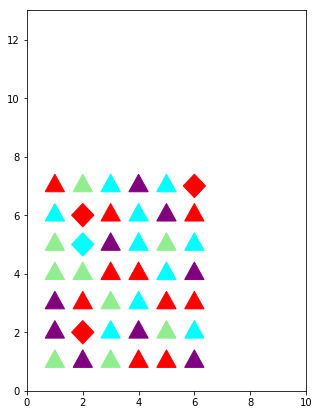

In [126]:
pic = s_before

fig, ax = plt.subplots(figsize=(5, 7))

ax.set_xlim((0, 10))
ax.set_ylim((0, 13))

circles = []

for ii in range(7):
    for jj in range(6):
        if (pic[ii, jj, 0] > 0):
            val = pic[ii, jj, 0]
            clr = "red"
        elif (pic[ii, jj, 1] > 0):
            val = pic[ii, jj, 1]
            clr = "lightgreen"
        elif (pic[ii, jj, 2] > 0):
            val = pic[ii, jj, 2]
            clr = "cyan"
        else:
            val = pic[ii, jj, 3]
            clr = "purple"
        
        if (val == 1):
            num_vertices = 3
        elif (val == 1.2):
            num_vertices = 4
        else:
            num_vertices = 5
            
        circles.append( mpatches.RegularPolygon((jj + 1, 7 - ii), numVertices=num_vertices, radius=0.4, color=clr) )

for circ in circles:
    ax.add_artist(circ)

In [1]:
GREAT_DICT = {1:1, 2:7, 3:19, 4:31, 5:43, 6:55, 7:2, 8:9, 9:21, 10:33, 11:45, 12:57, 13:3, 14:11, 15:23, 16:35, 17:47, 18:59, 
             19:4, 20:13, 21:25, 22:37, 23:49, 24:61, 25:5, 26:15, 27:27, 28:39, 29:51, 30:63, 31:6, 32:17, 33:29, 34:41,
             35:53, 36:65, 37:73, 38:81, 39:95, 40:109, 41:123, 42:74, 43:83, 44:97, 45:111, 46:125, 47:75, 48:85, 49:99,
             50:113, 51:127, 52:76, 53:87, 54:101, 55:115, 56:129, 57:77, 58:89, 59:103, 60:117, 61:131, 62:78, 63:91, 64:105,
             65:119, 66:133, 67:79, 68:93, 69:107, 70:121, 71:135}

In [26]:
#with open('replay_memory_4D_old.pickle', 'rb') as f:
#    replay_memory_old = pickle.load(f)

In [11]:
replay_memory_old_updated = []

for item in replay_memory_old:
    move71 = item[1]
    move142 = GREAT_DICT[move71]
    replay_memory_old_updated.append( (item[0], move142, item[2], item[3]) )

In [28]:
for item in replay_memory:
    replay_memory_old.append(item)

In [188]:
len(replay_memory)

11005

In [189]:
tmp = np.array([[1, 0, 2], [3, 3, 1], [0, 2, 0]])
tmp

array([[1, 0, 2],
       [3, 3, 1],
       [0, 2, 0]])

In [190]:
def myfunc(x):
    if (x > 0):
        x = 1 + (x - 1)*0.2
    
    return x

vfunc = np.vectorize(myfunc)

In [196]:
%%time
replay_memory_new = []
counter = 0

for item in replay_memory:
    tup = (vfunc(item[0]), item[1], item[2], vfunc(item[3]))

    replay_memory_new.append(tup)

Wall time: 1.23 s


In [97]:
predict_max_score(s_before, aero_cnn, number_of_moves)

(6.1822262, 116)